In [1]:
import sys

sys.path.append("../")

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from machine_learning.dataset_gen.station_dataframe_generator import StationDataframeGenerator
from window_generator import WindowGenerator

mpl.rcParams["figure.figsize"] = (8, 6)
mpl.rcParams["axes.grid"] = False

In [2]:
df = pd.read_feather("../../data/pollution/processed/interpolated/pm10/814.feather")
df.set_index("timestamp", inplace=True)

In [3]:
timestamp_s = df.index.map(pd.Timestamp.timestamp)

day = 24 * 60 * 60
year = (365.2425) * day

df["Day sin"] = np.sin(timestamp_s * (2 * np.pi / day))
df["Day cos"] = np.cos(timestamp_s * (2 * np.pi / day))
df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))
df.reset_index(inplace=True)



In [4]:
# Convert to radians.
wd_rad = df.pop("winddirection_10m") * np.pi / 180
df["winddirection_10m_sin"] = np.sin(wd_rad)
df["winddirection_10m_cos"] = np.cos(wd_rad)
df


,timestamp,temperature_2m,relativehumidity_2m,windspeed_10m,precipitation,pm10,Day sin,Day cos,Year sin,Year cos,winddirection_10m_sin,winddirection_10m_cos
0,2019-01-01 01:00:00,0.9,83,13.7,0.0,84.9443,2.588190e-01,0.965926,0.002738,0.999996,-0.996195,-0.087156
1,2019-01-01 02:00:00,0.6,82,14.8,0.0,59.5450,5.000000e-01,0.866025,0.003455,0.999994,-0.974370,-0.224951
2,2019-01-01 03:00:00,0.3,83,15.6,0.0,55.2941,7.071068e-01,0.707107,0.004172,0.999991,-0.945519,-0.325568
3,2019-01-01 04:00:00,0.3,85,15.2,0.0,39.3113,8.660254e-01,0.500000,0.004888,0.999988,-0.927184,-0.374607
4,2019-01-01 05:00:00,0.0,87,15.9,0.0,35.3945,9.659258e-01,0.258819,0.005605,0.999984,-0.838671,-0.544639
...,...,...,...,...,...,...,...,...,...,...,...,...
34400,2022-12-30 20:00:00,1.8,96,7.8,0.0,55.6152,-8.660254e-01,0.500000,-0.017532,0.999846,-0.224951,-0.974370
34401,2022-12-30 21:00:00,0.8,95,7.6,0.0,61.5726,-7.071068e-01,0.707107,-0.016815,0.999859,0.139173,-0.990268
34402,2022-12-30 22:00:00,0.2,95,7.9,0.0,72.9765,-5.000000e-01,0.866025,-0.016098,0.999870,0.406737,-0.913545
34403,2022-12-30 23:00:00,-0.1,94,9.9,0.0,74.3151,-2.588190e-01,0.965926,-0.015382,0.999882,0.544639,-0.838671


In [5]:
windowGenerator = WindowGenerator(input_width=24 * 7, label_width=24, shift=24, df=df.copy(), label_columns=["pm10"])

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-06-08 09:28:24.992737: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-08 09:28:24.993005: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
windowGenerator.plot(plot_col="pm10")

In [7]:
windowGenerator.plot(plot_col="winddirection_10m_cos")

In [8]:
input, labels = windowGenerator.split_window(windowGenerator.windows_train)

In [9]:
input.shape

TensorShape([23277, 168, 11])

In [10]:
windowGenerator.train.element_spec

(TensorSpec(shape=(None, 168, 11), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 24, 1), dtype=tf.float64, name=None))

In [11]:
for example_inputs, example_labels in windowGenerator.train.take(2):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  deb = example_inputs.numpy()
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 168, 11)
Labels shape (batch, time, features): (32, 24, 1)
Inputs shape (batch, time, features): (32, 168, 11)
Labels shape (batch, time, features): (32, 24, 1)


2023-06-08 09:28:56.093322: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [12]:
CONV_WIDTH = 6
num_features = 1
OUT_STEPS = 24
cnn_lstm_model = tf.keras.models.Sequential()
# Shape [batch, time, features] => [batch, CONV_WIDTH, features]
cnn_lstm_model.add(tf.keras.layers.Normalization())
cnn_lstm_model.add(tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]))
# Shape => [batch, 1, conv_units]
cnn_lstm_model.add(tf.keras.layers.Conv1D(128, activation="relu", kernel_size=(CONV_WIDTH), padding="same"))
cnn_lstm_model.add(tf.keras.layers.MaxPooling1D())
cnn_lstm_model.add(tf.keras.layers.BatchNormalization())  # TODO: useful to put it here?
cnn_lstm_model.add(tf.keras.layers.Conv1D(256, activation="relu", kernel_size=(CONV_WIDTH), padding="same"))
cnn_lstm_model.add(tf.keras.layers.MaxPooling1D())
cnn_lstm_model.add(tf.keras.layers.BatchNormalization())  # TODO: useful to put it here?
cnn_lstm_model.add(tf.keras.layers.Conv1D(256, activation="relu", kernel_size=(CONV_WIDTH), padding="same"))

cnn_lstm_model.add(tf.keras.layers.Reshape((-1, 256)))
# LSTM
cnn_lstm_model.add(tf.keras.layers.LSTM(32, return_sequences=False))
#cnn_lstm_model.add(tf.keras.layers.LSTM(32, return_sequences=False))

cnn_lstm_model.add(tf.keras.layers.Dense(512))
cnn_lstm_model.add(tf.keras.layers.Dropout(0.2))
cnn_lstm_model.add(tf.keras.layers.Dense(OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()))
# Shape => [batch, out_steps, features] -> for each prediction step one neuron
cnn_lstm_model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))



In [13]:
cnn_lstm_model.compile(
        loss=tf.keras.losses.MeanSquaredError(), optimizer="Adam", metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )

In [14]:

history = cnn_lstm_model.fit(
        windowGenerator.train, epochs=100, validation_data=windowGenerator.val,
    )

Epoch 1/100


2023-06-08 09:29:22.255519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-08 09:29:22.700379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-08 09:29:22.899777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


728/728 [==============================] - ETA: 0s - loss: 395.3257 - mean_absolute_error: 13.1138

2023-06-08 09:29:38.343247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-08 09:29:38.463108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


728/728 [==============================] - 19s 22ms/step - loss: 395.3257 - mean_absolute_error: 13.1138 - val_loss: 320.5312 - val_mean_absolute_error: 11.6083
Epoch 2/100
515/728 [====================>.........] - ETA: 6s - loss: 327.1649 - mean_absolute_error: 11.9564

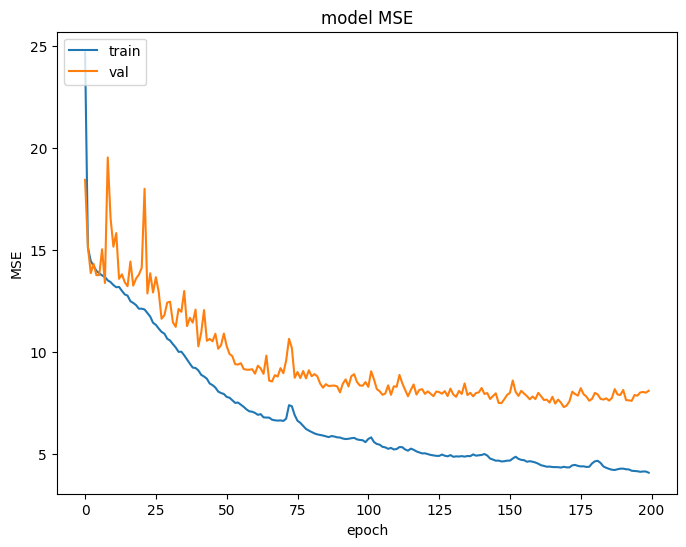

In [17]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
cnn_lstm_model.save("../models/cnn_lstm_14days_history_1days_pred_200_epochs_normalization")

INFO:tensorflow:Assets written to: ../models/cnn_lstm_14days_history_1days_pred_200_epochs_normalization/assets


INFO:tensorflow:Assets written to: ../models/cnn_lstm_14days_history_1days_pred_200_epochs_normalization/assets


In [24]:
windowGenerator.plot(cnn_lstm_model, offset=2)

In [37]:
cnn_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 168, 11)          23        
 n)                                                              
                                                                 
 lambda_2 (Lambda)           (None, 6, 11)             0         
                                                                 
 conv1d_6 (Conv1D)           (None, 6, 128)            8576      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 3, 128)           0         
 1D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 3, 128)           512       
 hNormalization)                                                 
                                                      